In [1]:
sourcefolder = r'C:\Users\Rory\raw_data\SERT_DREADD\good_eegchans'
recording = '401a_2018-04-18_17-40-36_CNO'

In [2]:
from OpenEphys import loadContinuous
from glob import glob
import os

def load_data(sourcefolder, recording, sep):
    os.chdir(sep.join([sourcefolder, recording]))
    continuous_files = glob('*.continuous')
    return loadContinuous(continuous_files[0])['data']

### I have an array: array

In [3]:
array = load_data(sourcefolder, recording, '\\')

Loading continuous data...


In [4]:
print('Type of data:\t{}'.format(type(array)))
print('Shape of data:\t{}'.format(array.shape))
print('\n'*2)
print('What the Data looks like: ')
print(array[:5])

Type of data:	<class 'numpy.ndarray'>
Shape of data:	(102048768,)



What the Data looks like: 
[-243.75  -269.685 -274.365 -254.085 -249.795]


### TODO:
 - Downsample from 30000Hz to 250Hz
 - Apply 100Hz low pass filter
 - Generate Power Spectral Density in 4 second Bins

In [5]:
# downsample + apply filter = scipy.signal.decimate?
from scipy import signal

downsampled_array = signal.decimate(array, 12, ftype='fir')
downsampled_array = signal.decimate(downsampled_array, 10,  ftype='fir')

In [6]:
print('Shape of data post downsampling:\t{}'.format(downsampled_array.shape))
print('Number of seconds in original array:\t{}'.format(array.shape[0]/30000))
print('Number of seconds in original array:\t{}'.format(downsampled_array.shape[0]/250))

Shape of data post downsampling:	(850407,)
Number of seconds in original array:	3401.6256
Number of seconds in original array:	3401.628


### How does the downsampling and filtering look?

In [7]:
import matplotlib.pyplot as plt

f, a = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
a[0].plot(array[:60000])
a[0].set_title('Original Array')
a[1].plot(downsampled_array[:500])
a[1].set_title('Downsampled Array')
plt.tight_layout()

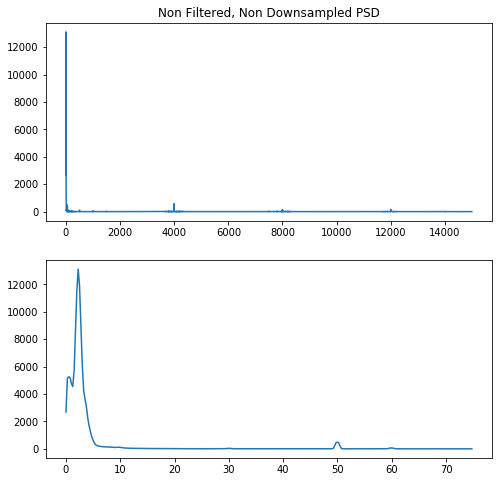

In [8]:
sampling_rate = 30000
bin_size = sampling_rate * 4
freqs, Pxx =signal.welch(x=array, fs=30000, 
              window= signal.get_window('flattop', bin_size),
              noverlap=500,
              nperseg=bin_size)

f, a =plt.subplots(nrows=2, figsize=(8,8))

a[0].plot(freqs, Pxx)
a[0].set_title('Non Filtered, Non Downsampled PSD')
a[1].plot(freqs[:300], Pxx[:300])

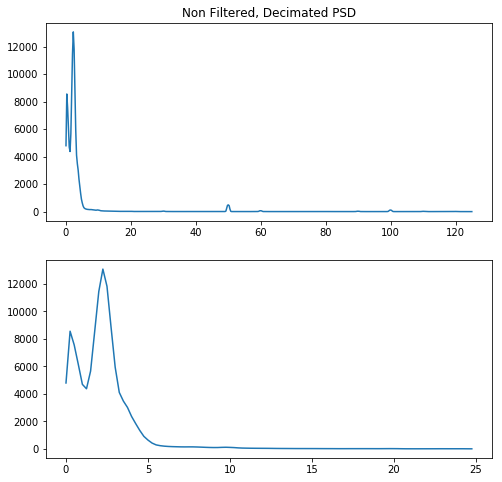

In [9]:
sampling_rate = 250
bin_size = sampling_rate * 4
freqs, Pxx =signal.welch(x=downsampled_array, fs=250, 
              window= signal.get_window('flattop', bin_size),
              noverlap=500,
              nperseg=bin_size)

f, a =plt.subplots(nrows=2, figsize=(8,8))
a[0].plot(freqs, Pxx)
a[0].set_title('Non Filtered, Decimated PSD')
a[1].plot(freqs[:100], Pxx[:100])

### Plotting spectrograms

In [10]:
import pandas as pd
import seaborn as sns
sampling_rate=250
bin_size = sampling_rate * 4

freqs, time, Sxx = signal.spectrogram(x=downsampled_array, fs=250, 
                                  window=signal.get_window('hanning', bin_size),
                                  nperseg=bin_size,
                                  noverlap=0,
                                nfft=bin_size)
df = pd.DataFrame(data=Sxx,
                  columns=time,
                  index=freqs).transpose()
df = df.reset_index().rename(columns={'index': 'time'})
df['time'] = pd.to_timedelta(df['time'], unit='s')
df.set_index('time', inplace=True)

In [11]:
df.head()

,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,...,122.75,123.0,123.25,123.5,123.75,124.0,124.25,124.5,124.75,125.0
time,,,,,,,,,,,,,,,,,,,,,
00:00:02,7337.120373,28721.217163,14262.700907,5546.574187,7628.895322,11764.380416,2426.967356,1361.453077,1916.571386,139.806250,...,3.175895,3.035259,2.040419,0.274554,0.127757,0.844179,2.373991,1.427277,1.269006,1.527442
00:00:06,11.765232,144.990432,884.131904,1644.129152,1417.756525,922.361773,3152.544746,2960.092009,2001.963674,2619.379245,...,2.753050,3.385859,2.345532,0.736424,0.059289,0.167146,0.024538,0.180379,0.006788,0.160171
00:00:10,8280.043204,26682.681607,13371.197315,18437.111294,6821.271139,2147.240810,5406.642243,3246.650412,332.998493,350.979976,...,0.238482,2.531896,2.085517,2.141796,0.983463,0.210551,0.032508,0.016007,0.005942,0.006321
00:00:14,4229.578620,6021.981007,2077.522494,3203.952933,166.078299,4226.873991,17509.402500,3992.964422,7107.213811,1193.972050,...,0.257068,0.166244,0.077673,0.025632,0.247646,0.378222,0.344949,0.055886,0.017989,0.002414
00:00:18,3306.667946,12264.463627,16083.135559,5985.605204,6468.989916,4826.282266,6991.773197,4717.412497,1432.048393,557.275593,...,0.820662,1.469286,0.845508,0.187936,0.004116,0.005165,0.000034,0.004968,0.058612,0.122637


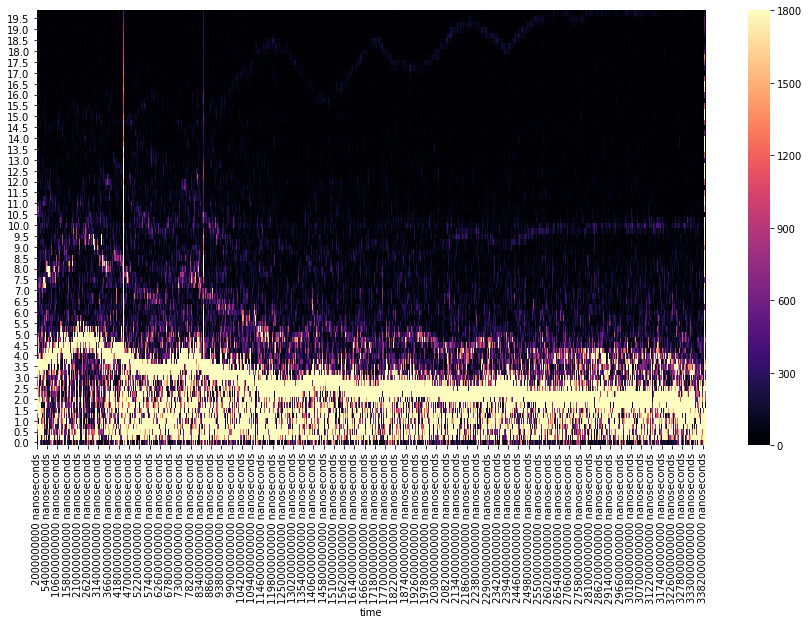

In [132]:
f, a = plt.subplots(figsize=(15,8))
df_lowf = df.iloc[:, :80]
a = sns.heatmap(df_lowf.transpose(), cmap='magma', 
                vmin=0, vmax=1800, ax=a)
a.invert_yaxis()
plt.show()